# N.B.: This is a deprecated analysis that was not used in the final paper.

## Transformer Attention Metrics

This notebook relies on the `narrative-transcript-processing` notebook to produce suitable TR-divided input, and the `transformer_utils` functions to produce different representations.

In [1]:
# Ensure that we re-load changes automagically
%load_ext autoreload
%autoreload 2

import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

from transformer_utils import TransformerRSM

STIMULUS = "slumlordreach" # 21st_year, pieman, slumlordreach, black

MODEL = 'bert-base-uncased' 
# BERT: bert-base-uncased, bert-large-uncased
# GPT: gpt2, gpt2-xl, gpt-neo-2.7B

foo = TransformerRSM(STIMULUS, model_name=MODEL, verbose=True)

Looking for TR-aligned tokens in data/stimuli/slumlordreach/tr_tokens.csv
Loaded 1177 TRs.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
ACTIVATIONS = False
Z_REPS = False

foo.process_stimulus_activations(save_activations=ACTIVATIONS, save_z_reps=Z_REPS)

/Users/sumers/opt/anaconda3/envs/bert-brains/lib/python3.9/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_lg' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Processing TR 0.

TR 0: Window Stimulus: This is the story of
	 TR stimulus: ['this', 'is', 'the', 'story', 'of']
Processing TR 100.

TR 100: Window Stimulus: I rent my apartments to anybody I want to And I said it so loud that the guy in the sound truck out front came busting out the back of the car blood gushing out of his ears and ran off down the street  So I kind of looked at Bob and said Wow that must have been quite a scream you made there    He kind of looked at me and then I think I got a lease I'm not sure I lived there for ten years I think I had a lease And
	 TR stimulus: ['think', 'i', 'had', 'a', 'lease', 'and']
Processing TR 200.

TR 200: Window Stimulus: Well it turns out they the city sent an engineer up there and the report on our building said something like A column of dust held up by a hundred and twenty five years of paint  That's literally a quote from the engineer's report and and I sort of knew that because whenever I went to hammer a nail into the wall to hang

# Produce Attention Vectors

In [7]:
# Median number of tokens per TR is 5; 75th percentile is 7.
# Assuming we're using about 30 seconds of prior context, that's 20 TRs, so we should take 100-140 context tokens.

N_ATTENTION_TOKENS = 128 # 10, 20, 128

In [8]:
foo.verbose = False
foo.process_stimulus_attentions(num_window_tokens=N_ATTENTION_TOKENS)

Processing TR 0


Token indices sequence length is longer than the specified maximum sequence length for this model (518 > 512). Running this sequence through the model will result in indexing errors


Processing TR 100
Processing TR 200
Processing TR 300
Processing TR 400
Processing TR 500
Processing TR 600
Processing TR 700
Processing TR 800
Processing TR 900
Processing TR 1000
Processing TR 1100


In [9]:
print("Successfully produced attention maps for {} of {} TRs.".format( 
    len(foo.stimulus_df[~foo.stimulus_df.attentions.isnull()]), len(foo.stimulus_df)))

Successfully produced attention maps for 1151 of 1177 TRs.


In [10]:
has_attentions = foo.stimulus_df[foo.stimulus_df.attentions.isnull()]
failed_attentions = foo.stimulus_df[~foo.stimulus_df.attentions.isnull()]

## Mask Attention to produce vectors

All of the below analyses can / should be run with various parameter settings.

They run much faster than the original activation / attention code and do various masking and summarization procedures on the raw data.

In [134]:
def flatten(lists):
    if lists is None:
        return None
    else:
        return list(itertools.chain.from_iterable(lists))

In [153]:
DIRECTIONS = ["bck"]#, "fwd"]
NORMS = []#"inf"] # can also do p=1 or 2, but not using those currently.

In [ ]:
for attention_direction in DIRECTIONS:

    foo.mask_non_tr_attentions(include_forwards=(attention_direction=="fwd"), 
                           include_backwards=(attention_direction=="bck"))


    for p in NORMS:  

        foo.compute_attention_head_magnitudes(p=p)
        attention_vectors = foo.stimulus_df["attention_heads_L{}".format(p)].apply(lambda x: flatten(x))
        attention_np_arrays = np.array(attention_vectors)

        complexity_output_file= "{}_{}_syntactic_complexity_L-{}_T-{}_D-{}.npy".format(STIMULUS, MODEL, p, N_ATTENTION_TOKENS, attention_direction)
        np.save(complexity_output_file, attention_np_arrays)
        
        print("Output metrics to {}".format(complexity_output_file))
        print(attention_np_arrays.shape)

# Attention Distance

In [11]:
attention_direction = "bck"

if attention_direction is not None:
    foo.mask_non_tr_attentions(include_forwards=(attention_direction=="fwd"), 
                               include_backwards=(attention_direction=="bck"))
    foo.compute_attention_head_distances()

else:    
    foo.compute_attention_head_distances(attention_col='attentions')
    
has_attentions = foo.stimulus_df[foo.stimulus_df.attention_distances.notnull()]["attention_distances"].values

Processing TR 0.
Processing TR 100.
Processing TR 200.
Processing TR 300.
Processing TR 400.
Processing TR 500.
Processing TR 600.
Processing TR 700.
Processing TR 800.
Processing TR 900.
Processing TR 1000.
Processing TR 1100.


In [12]:
head_distances = np.zeros((12, 12))

for tr in has_attentions:
    for i, layer in enumerate(tr):
        for j, head in enumerate(layer):
            head_distances[i][j] += tr[i][j]

head_distances = head_distances / len(has_attentions)

In [13]:
distance_output = "{}_{}_headwise-distance_T-{}_D-{}.npy".format(STIMULUS, MODEL, N_ATTENTION_TOKENS, attention_direction)
np.save(distance_output, head_distances)

In [14]:
distance_output_raw = "raw_{}_{}_headwise-distance_T-{}_D-{}.npy".format(STIMULUS, MODEL, N_ATTENTION_TOKENS, attention_direction)
np.save(distance_output_raw, has_attentions)

In [15]:
head_distances.shape

(12, 12)

Text(33.0, 0.5, 'Layer')

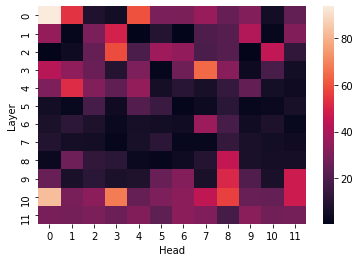

In [16]:
plt.figure()
sns.heatmap(head_distances)
plt.xlabel("Head")
plt.ylabel("Layer")

## Combining distances across stimuli

Used for the headwise-distance figure, subplot 5B.

In [18]:
attention_direction = "bck"
stimuli = ["slumlordreach", "black"]

distance_files_raw = "raw_{}_{}_headwise-distance_T-{}_D-{}.npy"

distance_inputs = [distance_files_raw.format(s, MODEL, N_ATTENTION_TOKENS, attention_direction) for s in stimuli]
distance_npy = [np.load(f, allow_pickle=True) for f in distance_inputs]
concated_distances = np.concatenate(distance_npy)

combined_head_distances = np.zeros((12, 12))

for tr in concated_distances:
    for i, layer in enumerate(tr):
        for j, head in enumerate(layer):
            combined_head_distances[i][j] += tr[i][j]

combined_head_distances = combined_head_distances / len(concated_distances)

out_file = "combined_black_slumlord_bert-base-uncased_headwise-distance_T-128_D-{}.npy".format(attention_direction)
np.save(out_file, combined_head_distances)

Text(33.0, 0.5, 'Layer')

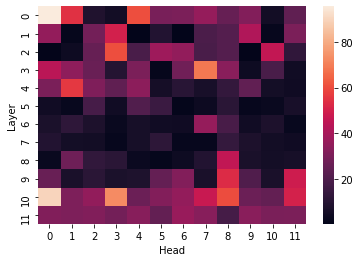

In [19]:
plt.figure()
sns.heatmap(combined_head_distances)
plt.xlabel("Head")
plt.ylabel("Layer")

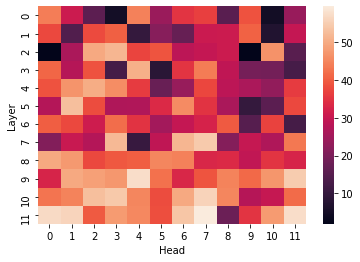

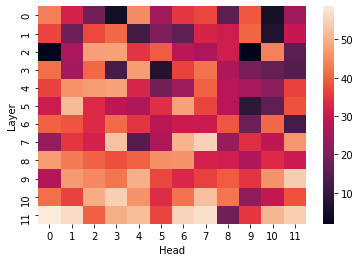

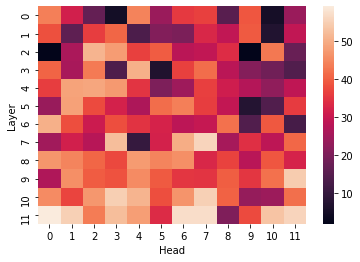

In [44]:
for x in [90, 150, 200]:
    plt.figure()
    sns.heatmap(foo.stimulus_df.attention_distances.iloc[x])
    plt.xlabel("Head")
    plt.ylabel("Layer")

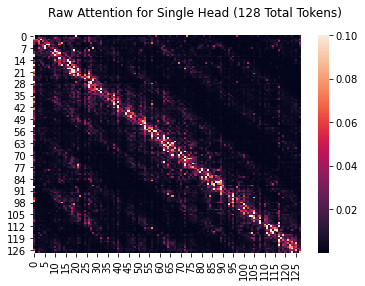

In [13]:
sns.heatmap(foo.stimulus_df.attentions.iloc[50][0][11], vmax=.1)
plt.suptitle("Raw Attention for Single Head ({} Total Tokens)".format(N_ATTENTION_TOKENS));

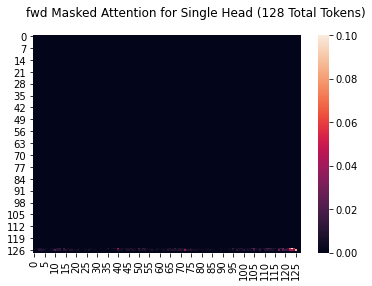

In [14]:
sns.heatmap(foo.stimulus_df.masked_attentions.iloc[50][0][11], vmax=.1)
plt.suptitle("{} Masked Attention for Single Head ({} Total Tokens)".format(attention_direction, N_ATTENTION_TOKENS));

## Output Attention Vector .npy's

In [38]:
def concatenate_fwd_bck_arrays(fwd, bck):

    res = []
    for f, b in zip(fwd, bck):
        if f is None and b is None:
            res.append(None)
        else:                
            res.append(f + b)
    res = np.array(res, dtype=object)
        
    return res

In [39]:
import glob

backwards_metrics = [f for f in glob.glob("*.npy") if 'bck' in f]

for backwards_file in backwards_metrics:
    
    bck = np.load(backwards_file, allow_pickle=True)
    forward_file = backwards_file.replace("bck", "fwd")
    fwd = np.load(forward_file, allow_pickle=True)
    
    concat = concatenate_fwd_bck_arrays(fwd, bck)
    concat_file = backwards_file.replace("bck", "concat")
    
    np.save(concat_file, concat)
    
    print("Concatenated\n===========")
    print("\tFile: {}".format(concat_file))
    print("\tTRs:{}".format(concat.shape[0]))
    print("\tDimensions: {}\n\n".format(len(concat[-1])))

Concatenated
	File: slumlordreach_bert-base-uncased_syntactic_complexity_L-inf_T-128_D-concat.npy
	TRs:1177
	Dimensions: 288


Concatenated
	File: black_bert-base-uncased_syntactic_complexity_L-inf_T-128_D-concat.npy
	TRs:534
	Dimensions: 288


Concatenated
	File: slumlordreach_gpt2_syntactic_complexity_L-inf_T-128_D-concat.npy
	TRs:1177
	Dimensions: 288


Concatenated
	File: black_bert-large-uncased_syntactic_complexity_L-inf_T-128_D-concat.npy
	TRs:534
	Dimensions: 768


Concatenated
	File: black_gpt2_syntactic_complexity_L-inf_T-128_D-concat.npy
	TRs:534
	Dimensions: 288




## SCP to PNI
```scp {FILE_NAME} tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/{STIMULUS}/{MODEL}/syntactic_analyses```

```ssh tsumers@apps.pni.princeton.edu```

In [40]:
ALL_SYNTAX_REPS = "scp {}_{}_syntactic_*concat.npy tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/{}/{}/syntactic_analyses"

print("SCP all syntactic representations to PNI:\n")
print(ALL_SYNTAX_REPS.format(STIMULUS, MODEL, STIMULUS, MODEL, STIMULUS, MODEL))

SCP all syntactic representations to PNI:

scp slumlordreach_bert-base-uncased_syntactic_*concat.npy tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/slumlordreach/bert-base-uncased/syntactic_analyses


# Compare old / new versions of metrics

In [ ]:
snapshot_metrics = [f for f in glob.glob("*.npy") if 'snapshot' in f]

for s in snapshot_metrics:

    snapshot = np.load(s, allow_pickle=True)
    new_file = s.split('snapshot-')[-1]
    
    try:
        new = np.load(new_file, allow_pickle=True)
    except FileNotFoundError:
        print("\nERROR: could not load {}".format(new_file))
        continue
    
    print("\n{}".format(new_file))
    print("\tShape: {}".format((snapshot.shape==new.shape)))
    try:
        print("\tClose: {}".format(np.allclose(snapshot, new)))
    except:
        pass
    print("\tComparison of TR 50 reps:")
    print("\t\tOld: {}".format(snapshot[50][:5]))
    print("\t\tNew: {}".format(new[50][:5]))